In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE


In [2]:
# Load dataset
df = pd.read_csv("fraud_detection_dataset.csv")

# Display first few rows
print(df.head())

                          TransactionID  CustomerID  TransactionAmount  \
0  5b1ee9a5-79d5-41a9-b796-2c822bc00488        8270        2833.262435   
1  6d2fc408-ff54-49b9-81cb-b664fca46381        1860        3404.762325   
2  e808407a-3e67-4afa-b297-663a9550dc5a        6390        3376.091549   
3  d39c04b1-4fca-4a67-a380-16343249e6cd        6191        1199.136588   
4  2dc4c909-f981-4868-89a1-7cf52d9da05a        6734        2315.429265   

   TransactionDateTime  MerchantID MerchantCategory TransactionType CardType  \
0  2023-07-28 03:01:31       79306           Retail      Withdrawal   Credit   
1  2022-02-11 04:05:14       29726           Retail        Purchase   Credit   
2  2025-01-25 18:21:12       19088      Electronics        Purchase    Debit   
3  2024-04-10 00:14:11       44314    Entertainment      Withdrawal  Prepaid   
4  2021-12-04 18:56:06       65041    Entertainment        Transfer    Debit   

     EntryMode TransactionLocation      IP_Address DeviceType  CardPresent

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TransactionID              5000 non-null   object 
 1   CustomerID                 5000 non-null   int64  
 2   TransactionAmount          5000 non-null   float64
 3   TransactionDateTime        5000 non-null   object 
 4   MerchantID                 5000 non-null   int64  
 5   MerchantCategory           5000 non-null   object 
 6   TransactionType            5000 non-null   object 
 7   CardType                   5000 non-null   object 
 8   EntryMode                  5000 non-null   object 
 9   TransactionLocation        5000 non-null   object 
 10  IP_Address                 5000 non-null   object 
 11  DeviceType                 5000 non-null   object 
 12  CardPresent                5000 non-null   int64  
 13  PreviousFraudTransactions  5000 non-null   int64

In [5]:
# Check for missing values
print(df.isnull().sum())

# Drop irrelevant columns
df = df.drop(columns=['TransactionID', 'CustomerID', 'MerchantID', 'TransactionDateTime'])
df.head()
df.columns

TransactionID                0
CustomerID                   0
TransactionAmount            0
TransactionDateTime          0
MerchantID                   0
MerchantCategory             0
TransactionType              0
CardType                     0
EntryMode                    0
TransactionLocation          0
IP_Address                   0
DeviceType                   0
CardPresent                  0
PreviousFraudTransactions    0
AccountAge                   0
DailyTransactionCount        0
DailyTransactionAmount       0
IsInternational              0
TimeSinceLastTransaction     0
FraudFlag                    0
dtype: int64


Index(['TransactionAmount', 'MerchantCategory', 'TransactionType', 'CardType',
       'EntryMode', 'TransactionLocation', 'IP_Address', 'DeviceType',
       'CardPresent', 'PreviousFraudTransactions', 'AccountAge',
       'DailyTransactionCount', 'DailyTransactionAmount', 'IsInternational',
       'TimeSinceLastTransaction', 'FraudFlag'],
      dtype='object')

In [19]:
# Fill missing values in 'IP_Address' with mode
df["IP_Address"] = df["IP_Address"].fillna(df["IP_Address"].mode()[0])

# Separate features and target variable
X = df.drop(columns=['FraudFlag'])
y = df['FraudFlag']

In [20]:
X.head()

,TransactionAmount,MerchantCategory,TransactionType,CardType,EntryMode,TransactionLocation,IP_Address,DeviceType,CardPresent,PreviousFraudTransactions,AccountAge,DailyTransactionCount,DailyTransactionAmount,IsInternational,TimeSinceLastTransaction
0,2833.262435,Retail,Withdrawal,Credit,Magstripe,Pamelaside,171.231.226.75,Tablet,0,4,596,5,6430.153621,1,66918
1,3404.762325,Retail,Purchase,Credit,Contactless,Camposview,22.174.135.157,POS,0,6,1014,5,5126.453239,1,71136
2,3376.091549,Electronics,Purchase,Debit,Online,Port Jenniferland,62.31.49.72,Mobile,1,3,540,8,2552.090223,1,75035
3,1199.136588,Entertainment,Withdrawal,Prepaid,Magstripe,Matthewfurt,98.6.224.64,Tablet,1,5,3351,2,4554.912188,1,46892
4,2315.429265,Entertainment,Transfer,Debit,Magstripe,Thomasstad,119.84.35.150,Mobile,0,7,12,9,2936.599542,1,41442


In [21]:
X.columns

Index(['TransactionAmount', 'MerchantCategory', 'TransactionType', 'CardType',
       'EntryMode', 'TransactionLocation', 'IP_Address', 'DeviceType',
       'CardPresent', 'PreviousFraudTransactions', 'AccountAge',
       'DailyTransactionCount', 'DailyTransactionAmount', 'IsInternational',
       'TimeSinceLastTransaction'],
      dtype='object')

In [22]:


# Identify categorical columns
categorical_cols = ["MerchantCategory", "TransactionType", "CardType", "EntryMode",
                    "DeviceType", "TransactionLocation", "IP_Address"]

# Apply Label Encoding to categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])  
    label_encoders[col] = le

# Save label encoders for future use
joblib.dump(label_encoders, "label_encoders.pkl")

# Verify all values are numeric
print("Updated Data Types:\n", X.dtypes)


Updated Data Types:
 TransactionAmount            float64
MerchantCategory               int64
TransactionType                int64
CardType                       int64
EntryMode                      int64
TransactionLocation            int64
IP_Address                     int64
DeviceType                     int64
CardPresent                    int64
PreviousFraudTransactions      int64
AccountAge                     int64
DailyTransactionCount          int64
DailyTransactionAmount       float64
IsInternational                int64
TimeSinceLastTransaction       int64
dtype: object


In [23]:
# Split into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to balance data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verify new class distribution
print("Class Distribution After SMOTE:")
print(y_train_smote.value_counts())

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)


Class Distribution After SMOTE:
FraudFlag
0    3140
1    3140
Name: count, dtype: int64


In [24]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f'\n{model_name} Accuracy: {accuracy:.2f}')
    print(f'{model_name} Classification Report:\n{class_report}')

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Fraud', 'Fraud'])
    disp.plot(cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return accuracy



Logistic Regression Results:

Logistic Regression Accuracy: 0.86
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      1346
           1       0.41      0.91      0.57       154

    accuracy                           0.86      1500
   macro avg       0.70      0.88      0.74      1500
weighted avg       0.93      0.86      0.88      1500



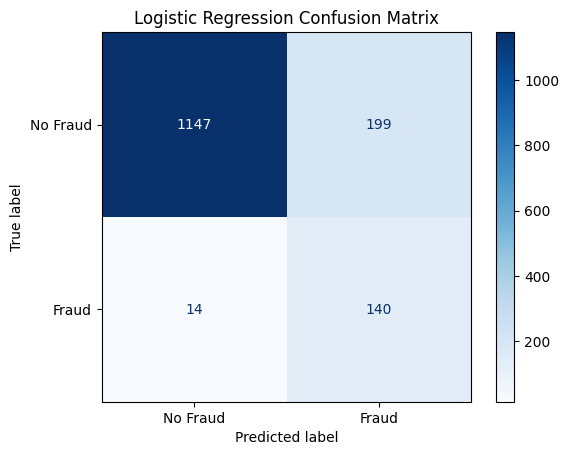

In [25]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_smote, y_train_smote)

print("\nLogistic Regression Results:")
log_reg_accuracy = evaluate_model(log_reg, X_test, y_test, "Logistic Regression")



Support Vector Machine Results:

Support Vector Classifier Accuracy: 0.90
Support Vector Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      1346
           1       0.50      0.81      0.62       154

    accuracy                           0.90      1500
   macro avg       0.74      0.86      0.78      1500
weighted avg       0.93      0.90      0.91      1500



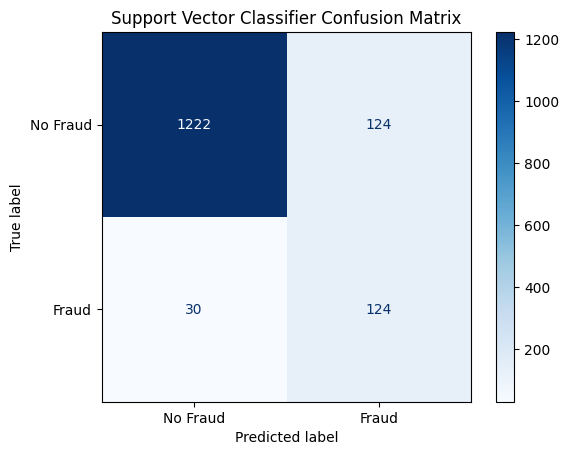

In [26]:
svc = SVC(probability=True, random_state=42)
svc.fit(X_train_smote, y_train_smote)

print("\nSupport Vector Machine Results:")
svc_accuracy = evaluate_model(svc, X_test, y_test, "Support Vector Classifier")



Random Forest Results:

Random Forest Accuracy: 0.91
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1346
           1       0.54      0.82      0.65       154

    accuracy                           0.91      1500
   macro avg       0.76      0.87      0.80      1500
weighted avg       0.93      0.91      0.92      1500



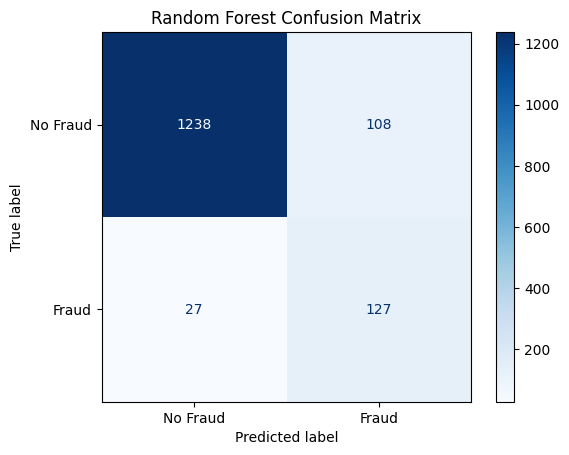

In [27]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_smote, y_train_smote)

print("\nRandom Forest Results:")
rf_accuracy = evaluate_model(rf, X_test, y_test, "Random Forest")


c:\Users\Lenovo\anaconda3\envs\nenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:21:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:

XGBoost Accuracy: 0.91
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1346
           1       0.55      0.75      0.64       154

    accuracy                           0.91      1500
   macro avg       0.76      0.84      0.79      1500
weighted avg       0.93      0.91      0.92      1500



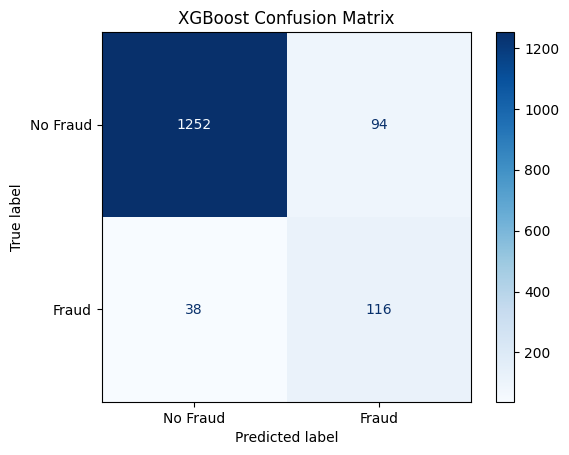

In [28]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train_smote, y_train_smote)

print("\nXGBoost Results:")
xgboost_accuracy = evaluate_model(xgb, X_test, y_test, "XGBoost")


In [29]:
# Get fraud probabilities
y_probs = xgb.predict_proba(X_test)[:, 1]  

# Adjust threshold (e.g., 0.3)
threshold = 0.3
y_pred_adjusted = (y_probs > threshold).astype(int)

print("\nClassification Report (Threshold Adjusted):")
print(classification_report(y_test, y_pred_adjusted))



Classification Report (Threshold Adjusted):
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1346
           1       0.55      0.82      0.66       154

    accuracy                           0.91      1500
   macro avg       0.76      0.87      0.80      1500
weighted avg       0.93      0.91      0.92      1500



In [30]:
# Choose the best model (e.g., XGBoost)
best_model = xgb  

# Save the model
filename = 'fraud_detection_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best Model Saved as {filename}")




Best Model Saved as fraud_detection_model.pkl


In [31]:
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']